## Trend reversion - Signal predictiveness

In [1]:
import numpy as np
import pandas as pd
import os
import pylab as P
from collections import defaultdict
import seaborn as sns
import warnings
from IPython.display import HTML, display, clear_output
from sgmbasketball.trading.strategies.trend_reversion.diagnostics import load_and_process
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
folder = '/home/dedwards/google_drive/trend_reversion_data/NBA/'

In [3]:
trend_rev = load_and_process(folder, reward_delay_limit=120, future_reward_window=20)

/home/dedwards/stratagem/stratagem-basketball/sgmbasketball/trading/strategies/trend_reversion/diagnostics.py:306: RuntimeWarning: invalid value encountered in greater
  nan_idx = df[reward_name + '_delay'].values > reward_delay_limit


In [4]:
def rgb_to_hex(rgb):
    rgb = [int(round(255*x)) for x in rgb[:3]]
    return '#{:0x}{:0x}{:0x}'.format(*rgb)

def attr_from_value(x, mn, mx, cm, cnan):
    
    col = rgb_to_hex(cm((x - mn) / (mx - mn))) if np.isfinite(x) else cnan
    return 'background-color: {}'.format(col)

def gradient2(data, cmap=sns.light_palette('plum', as_cmap=True), nan_col='#cccccc'):
    mn = data.min()
    mx = data.max()
    if data.ndim == 2:
        mn = mn.min()
        mx = mx.max()
        f = lambda x: attr_from_value(x, mn, mx, cmap, nan_col)
        return data.applymap(f)
    else:
        return data.apply(attr_from_value, args=(mn, mx, cmap, nan_col))

In [5]:
ind_cols = ['ind_ewmac_value',
            'ind_he_value',
            'ind_mk_value',
#             'ind_vhf_value',
            'ind_vr_value',
            'ind_wrp_value']
reward_cols = ['reward_max', 'reward_min', 'reward_mean']

def summary(trend_rev, reward_name, ind_cols=ind_cols, reward_cols=reward_cols):
    df = trend_rev[reward_name].set_index(reward_cols)[ind_cols].stack().reset_index()
    df.columns = ['reward_max', 'reward_min', 'reward_mean', 'ind', 'value']

    df = df.set_index(['ind', 'value']).groupby(level=['ind', 'value']).mean()
    df.columns.name = 'reward'

    df = df.stack().unstack('value')
    df.loc[:, -1] -= df.loc[:, 0]
    df.loc[:, 1] -= df.loc[:, 0]
    df = df.drop(0, axis=1)
    df = df.unstack('reward').reorder_levels([1, 0], axis=1).sort_index(axis=1)
    display(HTML('<b>{}</b>'.format(reward_name)))
    display(df.style.format('{:.2f}').apply(gradient2, axis=None))

In [6]:
summary(trend_rev, 'impl_home_win_ALL')
summary(trend_rev, 'impl_points_spread_ALL')
summary(trend_rev, 'impl_total_points_ALL')

In [11]:
df = trend_rev['impl_home_win_ALL']
events = sorted(list(set(df.event_id)))
n_events = len(events)
cutoff = int(0.5 * n_events)
events_train = events[:cutoff]
events_test = events[cutoff:]
train_df = df.loc[df.event_id.isin(events_train), :]
test_df = df.loc[df.event_id.isin(events_test), :]

In [38]:
train_df = train_df.dropna(subset=['score_h', 'score_a'])
test_df = test_df.dropna(subset=['score_h', 'score_a'])

In [12]:
from sklearn.linear_model import LinearRegression

In [15]:
class ProbabilityChecker(object):
    PERIOD_LEN = 720.
    MATCH_LEN = 4 * PERIOD_LEN
    def __init__(self, train_df, sd_th=2):
        self._sd_th = sd_th
        self._lm = None
        self._sd = None
        self.fit(train_df)
    
    @staticmethod
    def logit(p):
        return np.log(p / (1 - p))

    @staticmethod
    def inv_logit(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def get_features(df, dropna=True):
        df = df.loc[df.elapsed_bin < ProbabilityChecker.MATCH_LEN, :]
        df.loc[:, 't'] = df.elapsed_bin / ProbabilityChecker.MATCH_LEN
        df.loc[:, 'sd'] = df.score_h - df.score_a
        df.loc[:, 'tsd'] = df.t * df.sd
        if dropna:
            df = df.dropna(subset=['t', 'sd', 'tsd', 'impl_home_win_ALL'])
        X = df.loc[:, ['t', 'sd', 'tsd']].values
        y = ProbabilityChecker.logit(df.impl_home_win_ALL.values)
        return X, y
    
    def fit(self, train_df):
        X, y = self.get_features(train_df)
        self._lm = LinearRegression().fit(X, y)
        self._sd = (self._lm.predict(X) - y).std()

    def plot_model(self, df, as_logit=True):
        X, y = get_features(df)
        fig, ax = P.subplots(1, 2, figsize=(10, 4))
        ax[0].plot([-8, 8], [-8, 8], color='grey')
        ax[0].plot([-8, 8], [-5, 11], color='grey', linestyle='dashed')
        ax[0].plot([-8, 8], [-11, 5], color='grey', linestyle='dashed')
        sns.regplot(self._lm.predict(X), y, scatter_kws={'alpha': 0.1}, ax=ax[0])
        sns.distplot(self._lm.predict(X) - y, ax=ax[1])
        
    def set_is_valid(self, df):
        idx = df.elapsed_bin < ProbabilityChecker.MATCH_LEN
        X, y = self.get_features(df.loc[idx, :], dropna=False)
        df.loc[idx, 'is_valid'] = np.abs((self._lm.predict(X) - y)) < self._sd * self._sd_th
        return df

In [39]:
pc = ProbabilityChecker(train_df)
train_df = pc.set_is_valid(train_df)
test_df = pc.set_is_valid(test_df)

/home/dedwards/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


In [18]:
def weighted_indicator(row, ind_weights):
    w_ind = 0.
    for nn, ww in ind_weights.iteritems():
        w_ind += ww * np.nan_to_num(row['ind_{}_value'.format(nn)])
    return w_ind

def trade_event_ft12(event_df, **config):
    th = 0.99
    impl = 'impl_home_win_ALL'
    event_df = event_df.sort_values('elapsed_bin')
    
    bet_open = False
    open_side = None
    open_odds = -1
    open_el = -1
    bets = []
    total_return = 0.
    
    for _, row in event_df.iterrows():
        if np.isnan(row[impl]) or not row.is_valid:
            continue

        weighted_ind = weighted_indicator(row, config['ind_weights'])
        
        home_odds = 1 / row[impl]
        away_odds = 1 / (1 - row[impl])
        if bet_open:
            # Look to close
            close_odds = home_odds if open_side == 'H' else away_odds
            pnl = open_odds / close_odds - 1.
            if pnl > config['take_profit'] or pnl < -config['stop_loss']:
                # Do close
                bets.append({'open_odds': open_odds, 'close_odds': close_odds, 'open_side': open_side,
                             'open_el': open_el, 'close_el': row.elapsed_bin, 'pnl': pnl})
                bet_open = False
        else:
            # Look to open
            if row['elapsed_bin'] <= config['last_bet_elapsed']:
                if weighted_ind > th:
                    # Back home
                    open_odds = home_odds
                    bet_open = True
                    open_side = 'H'
                elif weighted_ind < -th:
                    # Back away
                    open_odds = away_odds
                    bet_open = True
                    open_side = 'A'
            if bet_open:
                open_el = row.elapsed_bin
                    
    if bet_open:
        is_win = (open_side == 'H' and row.score_h > row.score_a) or \
                 (open_side == 'A' and row.score_h < row.score_a)
        pnl = open_odds - 1 if is_win else -1.
        close_odds = 1. if is_win else np.inf
        bets.append({'open_odds': open_odds, 'close_odds': close_odds, 'open_side': open_side,
                     'open_el': open_el, 'close_el': np.inf, 'pnl': pnl})

    if len(bets) == 0:
        return None
        
    bets_df = pd.DataFrame(bets)
    bets_df.loc[:, 'duration'] = bets_df.close_el - bets_df.open_el
    bets_df.loc[:, 'is_closed'] = np.isfinite(bets_df.close_el) 
    
    cols = ['open_el', 'open_side', 'open_odds', 'close_el', 'close_odds', 'pnl', 'duration', 'is_closed']
    return bets_df.loc[:, cols]

In [19]:
def get_bets(df, config, q=0.99):
    bets_df = df.groupby('event_id').apply(trade_event_ft12, **config)
    bets_df.index = bets_df.index.droplevel(-1)

    # Filter out the top 1% of closed bets
    bets_df = bets_df.loc[(bets_df.pnl <= bets_df.pnl.quantile(q)) | (~bets_df.is_closed), :]
    
    return bets_df

In [20]:
config = {
    'last_bet_elapsed': 1800,
    'take_profit': 0.2,
    'stop_loss': 0.2,
}

def add_weights_to_config(ind_w, config):
    cfg = config.copy()
    cfg['ind_weights'] = ind_w
    return cfg

In [364]:
bets_df = get_bets(train_df, add_weights_to_config({'mk': 2., 'ewmac': 1.}, config))

In [365]:
bets_df.shape

(2085, 8)

In [366]:
bets_df.groupby('is_closed').pnl.sum()

is_closed
False    15.328970
True     27.022086
Name: pnl, dtype: float64

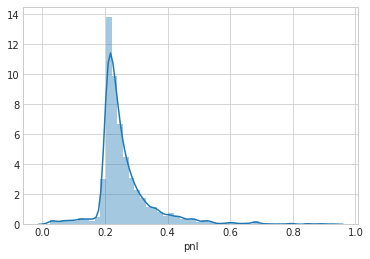

In [355]:
sns.distplot(bets_df.pnl.abs())

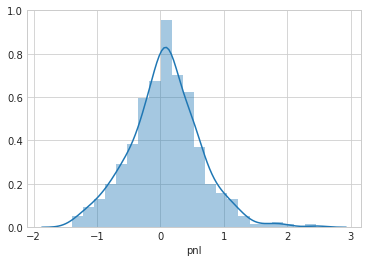

In [357]:
sns.distplot(bets_df.groupby(level='event_id').pnl.sum())

In [356]:
bets_df.loc[bets_df.groupby(level='event_id').pnl.sum().argmax()]

,open_el,open_side,open_odds,close_el,close_odds,pnl,duration,is_closed
event_id,,,,,,,,
ENP2353437,292.5,H,2.229366,727.5,1.835443,0.214620,435.0,True
ENP2353437,742.5,H,1.787568,832.5,1.457625,0.226357,90.0,True
ENP2353437,847.5,H,1.444719,1537.5,1.196018,0.207941,690.0,True
ENP2353437,1582.5,A,4.022786,1612.5,2.089635,0.925114,30.0,True
ENP2353437,1642.5,A,4.416173,1657.5,3.453342,0.278811,15.0,True
ENP2353437,1672.5,A,3.607254,1747.5,2.986044,0.208038,75.0,True
ENP2353437,1777.5,A,2.703085,1927.5,1.932392,0.398829,150.0,True


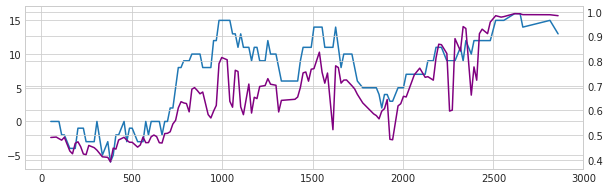

In [358]:
df = train_df.loc[(train_df.event_id == 'ENP2353437') & train_df.is_valid, :]

fig, ax = P.subplots(1, 1, figsize=(10, 3))
ax.plot(df.elapsed_bin, df.score_h - df.score_a)
ax2 = ax.twinx()
ax2.plot(df.elapsed_bin, df.impl_home_win_ALL, color='purple')

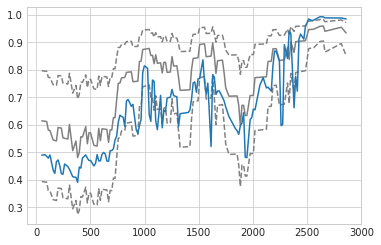

In [360]:
x = pc._lm.predict(pc.get_features(df)[0])
P.plot(df.elapsed_bin, ProbabilityChecker.inv_logit(x), color='grey')
P.plot(df.elapsed_bin, ProbabilityChecker.inv_logit(x - pc._sd * 2), color='grey', linestyle='dashed')
P.plot(df.elapsed_bin, ProbabilityChecker.inv_logit(x + pc._sd * 2), color='grey', linestyle='dashed')
P.plot(df.elapsed_bin, df.impl_home_win_ALL)

In [350]:
indicators = ['mk', 'vhf', 'ewmac', 'vr', 'wrp', 'he', 'vhf']
ind_bets_df = []
for ind in indicators:
    bdf = get_bets(train_df, add_weights_to_config({ind: 1.}, config)).reset_index()
    bdf.loc[:, 'ind'] = ind
    ind_bets_df.append(bdf)
ind_bets_df = pd.concat(ind_bets_df)

In [351]:
ind_bets_df.groupby('ind').pnl.sum()

ind
ewmac    25.468622
he       -2.416812
mk       37.415137
vhf      -1.309114
vr       -5.695653
wrp     -15.107249
Name: pnl, dtype: float64

In [51]:
from sgmtradingcore.backtesting.ga_optimizer import ChooseParamsGA
class OptimizeIndicatorWeights(ChooseParamsGA):
    """
    Test of the choose parameters method
    """

    def __init__(self, indicators, train_df, config, **kwargs):
        self._indicators = indicators
        self._train_df = train_df
        self._config = config
        ChooseParamsGA.__init__(self, **kwargs)

    @property
    def param_def(self):
        if self._param_def is None:
            n_indicators = len(self._indicators)
            temp = {'type': 'continuous', 'args': [-n_indicators, n_indicators]}
            self._param_def = dict((indicator, temp) for indicator in self._indicators)
        return self._param_def

    def evaluate(self, ind):
        ind_config = add_weights_to_config(ind, config)
        bets_df = get_bets(self._train_df, ind_config)
        return bets_df.pnl.sum(),

## Optimization 1

Configuration:
    
```
{'last_bet_elapsed': 1800, 'stop_loss': 0.2, 'take_profit': 0.2}
```

In [390]:
indicators = ['mk', 'vhf', 'ewmac', 'vr', 'wrp', 'he', 'vhf']
opt = OptimizeIndicatorWeights(indicators, train_df, config, npop=100, lambda_=20, mu=20, ngen=10, nhof=10)
opt.evolve()

gen	nevals	avg    	min     	max    
0  	100   	3.52174	-22.5151	33.6764
1  	15    	19.7905	-5.39475	32.394 
2  	11    	30.7365	26.7372 	34.4586
3  	14    	32.944 	28.5277 	37.5314
4  	17    	35.6361	32.394  	37.8754
5  	18    	37.3689	34.4586 	38.0179
6  	10    	37.8595	37.5314 	38.0179
7  	13    	37.9529	37.8754 	38.143 
8  	12    	38.0341	37.8754 	38.143 
9  	12    	38.1055	38.0179 	38.143 
10 	15    	38.143 	38.143  	38.143 
11 	13    	38.143 	38.143  	38.143 
12 	16    	38.143 	38.143  	38.143 
13 	13    	38.143 	38.143  	38.143 
14 	14    	38.143 	38.143  	38.143 
15 	9     	38.143 	38.143  	38.143 
16 	16    	38.143 	38.143  	38.143 
17 	15    	38.143 	38.143  	38.143 
18 	12    	38.143 	38.143  	38.143 
19 	14    	38.143 	38.143  	38.143 
20 	14    	38.143 	38.143  	38.143 


In [125]:
def hof_table(opt, v=1):
    tbl = []
    for ind in opt.hof.items:
        f = ind.fitness.values[0]
        ind = dict(ind)
        ind['score'] =f
        tbl.append(ind)
    if v == 1:
        return pd.DataFrame(tbl).loc[:, indicators + ['score']]
    elif v == 2:
        return pd.DataFrame(tbl).loc[:, ['take_profit', 'stop_loss'] + map(lambda x: 'ind_' + x, indicators) + 
                                        ['score']]
    else:
        return None
hof_table(opt)

,mk,vhf,ewmac,vr,wrp,he,vhf,score
0,5.769662,-2.862564,1.926499,-0.800850,0.603682,-0.798748,-2.862564,43.984249
1,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
2,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
3,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
4,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
5,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
6,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
7,4.128564,-1.368710,6.139310,-3.859032,-7.000000,-0.101613,-1.368710,33.842271
8,0.608493,-7.000000,2.985282,-7.000000,-5.465940,1.846543,-7.000000,33.099145
9,1.044398,-5.421014,6.600594,-6.021374,-6.604675,5.487513,-5.421014,33.094369


In [21]:
opt_weights = {'mk': 5.570198, 'vhf': -6.074304, 'ewmac': 6.154702, 
               'vr': -7.0, 'wrp': -7.0, 'he': 0.543209, 'vhf': -6.074304}

Optimized weights:
    
```
{'ewmac': 6.154702,
 'he': 0.543209,
 'mk': 5.570198,
 'vhf': -6.074304,
 'vr': -7.0,
 'wrp': -7.0}
```

In [40]:
opt_cfg = add_weights_to_config(opt_weights, config)
train_bets_df = get_bets(train_df, opt_cfg)
test_bets_df = get_bets(test_df, opt_cfg)

In [104]:
print train_bets_df.pnl.sum(), test_bets_df.pnl.sum()
print train_bets_df.pnl.mean(), test_bets_df.pnl.mean()

38.1429854246 39.2013867655
0.0192836124492 0.0189745337684


## Optimization 2

Configuration:
    
```
{'last_bet_elapsed': 1800, 'stop_loss': 0.3, 'take_profit': 0.3}
```

In [86]:
config2 = {'last_bet_elapsed': 1800, 'stop_loss': 0.3, 'take_profit': 0.3}

In [52]:
indicators = ['mk', 'vhf', 'ewmac', 'vr', 'wrp', 'he', 'vhf']
opt2 = OptimizeIndicatorWeights(indicators, train_df, config2, npop=100, lambda_=20, mu=20, ngen=10, nhof=10)
opt2.evolve()

gen	nevals	avg    	min     	max    
0  	100   	6.80114	-24.0741	43.9842
1  	15    	25.1455	0.924887	33.0944
2  	14    	30.3856	26.8192 	34.1958
3  	16    	32.9799	28.3835 	34.1958
4  	12    	34.0857	33.0944 	34.1958
5  	10    	34.1958	34.1958 	34.1958
6  	15    	34.1958	34.1958 	34.1958
7  	13    	34.1958	34.1958 	34.1958
8  	17    	34.1958	34.1958 	34.1958
9  	14    	34.1958	34.1958 	34.1958
10 	13    	34.1958	34.1958 	34.1958


In [56]:
hof_table(opt2)

,mk,vhf,ewmac,vr,wrp,he,vhf,score
0,5.769662,-2.862564,1.926499,-0.800850,0.603682,-0.798748,-2.862564,43.984249
1,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
2,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
3,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
4,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
5,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
6,0.608493,-5.720344,2.985282,-7.000000,-5.465940,1.846543,-5.720344,34.195832
7,4.128564,-1.368710,6.139310,-3.859032,-7.000000,-0.101613,-1.368710,33.842271
8,0.608493,-7.000000,2.985282,-7.000000,-5.465940,1.846543,-7.000000,33.099145
9,1.044398,-5.421014,6.600594,-6.021374,-6.604675,5.487513,-5.421014,33.094369


In [91]:
opt_weights2 = {'mk': 5.769662, 'vhf': -2.862564, 'ewmac': 1.926499, 
                'vr': -0.800850, 'wrp': 0.603682, 'he': -0.798748, 'vhf': -2.862564}

In [88]:
# opt_weights2 = {'mk': 0.608493, 'vhf': -5.720344, 'ewmac': 2.985282, 
#                 'vr': -7.000000, 'wrp': -5.465940, 'he': 1.846543, 'vhf': -5.720344}

Optimized weights:
    
```
{'ewmac': 1.926499,
 'he': -0.798748,
 'mk': 5.769662,
 'vhf': -2.862564,
 'vr': -0.80085,
 'wrp': 0.603682}
```

In [92]:
opt_cfg2 = add_weights_to_config(opt_weights2, config2)
train_bets_df2 = get_bets(train_df, opt_cfg2)
test_bets_df2 = get_bets(test_df, opt_cfg2)

In [103]:
print train_bets_df2.pnl.sum(), test_bets_df2.pnl.sum()
print train_bets_df2.pnl.mean(), test_bets_df2.pnl.mean()

24.6036489195 57.5981351131
0.0197937642152 0.0434375076267


## Optimization 3

Configuration:
    
```
{'last_bet_elapsed': 1800, 'stop_loss': 0.3, 'take_profit': 0.2}
```

In [94]:
config3 = {'last_bet_elapsed': 1800, 'stop_loss': 0.3, 'take_profit': 0.2}

In [95]:
indicators = ['mk', 'vhf', 'ewmac', 'vr', 'wrp', 'he', 'vhf']
opt3 = OptimizeIndicatorWeights(indicators, train_df, config3, npop=100, lambda_=20, mu=20, ngen=10, nhof=10)
opt3.evolve()

gen	nevals	avg    	min    	max    
0  	100   	4.36317	-29.687	36.1572
1  	15    	22.9875	3.50377	36.1572
2  	15    	30.279 	25.3165	36.1572
3  	15    	33.9282	28.7281	36.4926
4  	19    	35.7894	30.3572	36.4926
5  	12    	36.2746	36.1572	36.4926
6  	14    	36.4758	36.1572	36.4926
7  	15    	36.4926	36.4926	36.4926
8  	15    	36.4926	36.4926	36.4926
9  	12    	36.4926	36.4926	36.4926
10 	14    	36.4926	36.4926	36.4926


In [96]:
hof_table(opt3)

,mk,vhf,ewmac,vr,wrp,he,vhf,score
0,0.439096,1.978512,3.070219,-5.715187,2.889078,-1.048573,1.978512,36.492560
1,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
2,0.439096,1.983618,3.070219,-5.715187,2.889078,-1.048573,1.983618,36.492560
3,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
4,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
5,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
6,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
7,0.439096,2.018211,3.070219,-5.715187,2.889078,-1.048573,2.018211,36.492560
8,0.439096,1.964257,3.070219,-5.715187,2.889078,-1.048573,1.964257,36.492560
9,0.439096,1.964257,3.284078,-5.715187,2.889078,-1.048573,1.964257,36.490602


In [99]:
opt_weights3 = opt3.hof.items[0]

Optimized weights:
    
```
{'ewmac': 3.070219123254688,
 'he': -1.0485733440662814,
 'mk': 0.4390962774373719,
 'vhf': 1.9785116416593937,
 'vr': -5.715186806401092,
 'wrp': 2.8890782384957756}
```

In [100]:
opt_cfg3 = add_weights_to_config(opt_weights3, config3)
train_bets_df3 = get_bets(train_df, opt_cfg3)
test_bets_df3 = get_bets(test_df, opt_cfg3)

In [102]:
print train_bets_df3.pnl.sum(), test_bets_df3.pnl.sum()
print train_bets_df3.pnl.mean(), test_bets_df3.pnl.mean()

28.8923158762 33.3547111009
0.019775712441 0.0224007462061


## Optimization 4

In [135]:
from sgmtradingcore.backtesting.ga_optimizer import ChooseParamsGA
class OptimizeIndicatorWeights2(ChooseParamsGA):
    """
    Test of the choose parameters method
    """

    def __init__(self, indicators, train_df, config, **kwargs):
        self._indicators = indicators
        self._train_df = train_df
        self._config = config
        ChooseParamsGA.__init__(self, **kwargs)

    @property
    def param_def(self):
        if self._param_def is None:
            n_indicators = len(self._indicators)
            temp = {'type': 'continuous', 'args': [-n_indicators, n_indicators]}
            self._param_def = dict(('ind_' + indicator, temp) for indicator in self._indicators)
            self._param_def.update({
                'stop_loss': {'type': 'continuous', 'args': [0.1, 0.5]},
                'take_profit': {'type': 'continuous', 'args': [0.1, 0.5]},
            })
        return self._param_def

    @staticmethod
    def config_with_ind(config, ind):
        ind_config = config.copy()
        ind_weights = {k.replace('ind_', ''): v for k, v in ind.iteritems() if k.startswith('ind_')}
        other_config = {k: v for k, v in ind.iteritems() if not k.startswith('ind_')}
        ind_config.update(other_config)
        ind_config = add_weights_to_config(ind_weights, ind_config)
        return ind_config
    
    def evaluate(self, ind):
        ind_config = self.config_with_ind(self._config, ind)
        bets_df = get_bets(self._train_df, ind_config)
        return bets_df.pnl.sum(),

Configuration:
    
```
{'last_bet_elapsed': 1800}
```

In [136]:
config4 = {'last_bet_elapsed': 1800}

In [137]:
indicators = ['mk', 'vhf', 'ewmac', 'vr', 'wrp', 'he', 'vhf']
opt4 = OptimizeIndicatorWeights2(indicators, train_df, config4, npop=100, lambda_=20, mu=20, ngen=10, nhof=10)
opt4.evolve()

gen	nevals	avg   	min     	max    
0  	100   	5.1269	-42.3147	39.1175
1  	14    	24.3002	5.17768 	39.1175
2  	13    	33.2297	22.7948 	39.1175
3  	11    	38.8804	34.3758 	39.1175
4  	12    	39.1175	39.1175 	39.1175
5  	14    	39.1175	39.1175 	39.1175
6  	12    	39.1175	39.1175 	39.1175
7  	14    	39.1175	39.1175 	39.1175
8  	14    	39.7071	39.1175 	43.0479
9  	14    	40.7122	39.1175 	43.2728
10 	14    	42.9301	39.1175 	43.2728


In [138]:
hof_table(opt4, v=2)

,take_profit,stop_loss,ind_mk,ind_vhf,ind_ewmac,ind_vr,ind_wrp,ind_he,ind_vhf,score
0,0.206649,0.50000,0.631305,-1.758887,0.428285,-7.000000,4.025240,-7.000000,-1.758887,43.272807
1,0.206649,0.50000,-5.756406,-1.758887,0.428285,-7.000000,-5.331279,-7.000000,-1.758887,43.047899
2,0.206649,0.50000,-5.756406,-1.758887,0.428285,-7.000000,-6.207643,-7.000000,-1.758887,41.639841
3,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
4,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
5,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
6,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
7,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
8,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535
9,0.108946,0.36853,-0.535751,-1.758887,0.428285,-6.995701,1.569021,-4.479436,-1.758887,39.117535


In [142]:
opt_weights4 = opt4.hof.items[0]

Optimized weights:
    
```
{'ind_ewmac': 0.42828483725431,
 'ind_he': -7,
 'ind_mk': 0.6313048106674977,
 'ind_vhf': -1.7588871566722863,
 'ind_vr': -7,
 'ind_wrp': 4.025240170921857,
 'stop_loss': 0.5,
 'take_profit': 0.20664873861519092}
```

In [140]:
opt_cfg4 = OptimizeIndicatorWeights2.config_with_ind(config4, opt_weights4)
train_bets_df4 = get_bets(train_df, opt_cfg4)
test_bets_df4 = get_bets(test_df, opt_cfg4)

In [141]:
print train_bets_df4.pnl.sum(), test_bets_df4.pnl.sum()
print train_bets_df4.pnl.mean(), test_bets_df4.pnl.mean()

43.2728067613 46.8186491887
0.0383624173416 0.040187681707


## Backtest results

In [9]:
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display, HTML
from stratagemdataprocessing.dbutils.mongo import MongoPersister
import sgmbasketball.trading.backtesting.backtest_configs as configs

from sgmbasketball.trading.backtesting.backtest_metrics import BacktestMetrics
from sgmbasketball.trading.backtesting.backtest_tables_and_figures import visualize_metrics, hide_code
from sgmtradingcore.backtesting.persistence import MongoStrategyHelper
import numpy as np
from collections import OrderedDict

pd.options.display.max_rows = 200
pd.options.display.float_format = '{:,.3f}'.format
sns.set_style('whitegrid')

# %matplotlib inline
clear_output()

In [10]:
strategy_desc = 'bball_trend_reversion'
strategy_code = 'nba_test'

start_date = '2016-12-01'
end_date = '2018-01-01'

In [11]:
backtest_config = {'mnemonic': 'nba_test',
                   'strategy_code': 'default',
                   'strategy_desc': 'nba_1',
                   'strategy_name': 'bball_trend_reversion',
                   'trading_user_id': '54da2b5fd47e6bff0dade9b4'}
br = BacktestMetrics(start_date=start_date, end_date=end_date, backtest_config=backtest_config, comp='NBA',
                     original_sizing=True, group_by=None)
clear_output()

In [12]:
display(br._all_sc_generic_metrics)
orders_df = br.get_orders_df(('original', ), add_value=False)
plot_out = br.plot_cum_returns_all_sizers()

,n_trades,n_win,n_loss,hit_ratio,average_trade_win,average_trade_loss,unitary_stake_return,cr_trade,cr_day,cum_return,volatility (not annualised),sharpe_ratio,maximum_drawdown,drawdown_duration (days),maximum_runup,runup_duration (days),total_pnl,n_trading_days,vol_scale,corrected_sharpe_ratio
0,7530,3990,3540,0.530,0.002,0.002,-0.010,0.975,0.847,-0.205,0.227,-0.903,-0.439,119.000,0.297,242.000,"-2,050.564",243.000,nan,nan


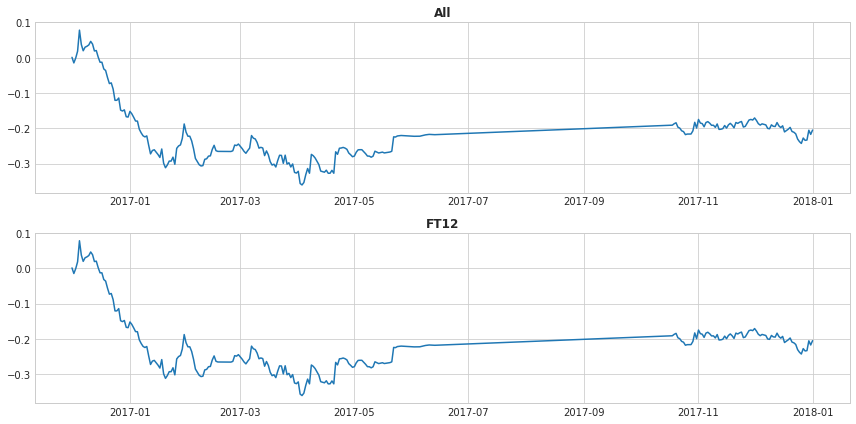

In [13]:
plot_out[0][1]

In [14]:
from collections import Counter

In [15]:
Counter([i['details']['trade_intention']['name'] for i in br._backtest_resizer.instructions])

Counter({u'CloseTrade': 2288, u'OpenTradeSingleSticker': 5264})